In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import time
from tqdm import tqdm
import sys
import os
sys.path.append(os.path.abspath('..'))
from kans import BSplineKAN, FourierKAN, GaussianKAN, JacobiKAN, RationalKAN, TaylorKAN, WaveletKAN, BernsteinKAN, MLP

torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [2]:
def train(model, train_loader, num_epochs=50, save=False, model_name=''):
	print('-'*50)
	print(f'Training {model_name} model...')
	optimizer = optim.Adam(model.parameters(), lr=0.01)
	criterion = nn.MSELoss() # Use MSELoss for regression
	epoch_losses = []
	bar = tqdm(total=num_epochs)
	start_t = time.time()
	for epoch in range(num_epochs):
		running_loss = 0.0
		for i, (inputs, labels) in enumerate(train_loader):
            # Forward pass
			outputs = model(inputs)
			loss = criterion(outputs, labels)
            
            # Backward and optimize
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()
            
            # Record loss
			running_loss += loss.item()
        
        # Print information every certain steps
		epoch_loss = running_loss / len(train_loader)
		epoch_losses.append(epoch_loss)
		bar.set_description(f'{model_name} Epoch {epoch+1}')
		bar.set_postfix(loss=f'{epoch_loss:.4f}')
		bar.update(1)
	bar.close()
	end_t = time.time()
	epoch_time = (end_t - start_t) / num_epochs
	print(f'Average Epoch Training Time :{epoch_time}s')
	if save:
		torch.save(model.state_dict(), f'model/{model_name}.pth')
		print(f'Model saved as model/{model_name}.pth')
	return epoch_losses, epoch_time

def test(model, test_input, test_label, model_name):
	criterion = nn.MSELoss()
	model.eval()
	with torch.no_grad():
		test_output = model(test_input)
		test_loss = criterion(test_output, test_label).item()
	print(f'Test Loss of {model_name} model: {test_loss}')
	return test_loss

In [3]:
# Generate dataset
dataset = fetch_california_housing()
X = dataset.data
y = dataset.target
scaler = StandardScaler()
X = scaler.fit_transform(X) # Standardize the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = torch.tensor(X_train, dtype=torch.float64, device=device)
print('train_input size:', X_train.shape)
X_test = torch.tensor(X_test, dtype=torch.float64, device=device)
print('test_input size:', X_test.shape)
y_train = torch.tensor(y_train, dtype=torch.float64, device=device).unsqueeze(1)
print('train_label size:', y_train.shape)
y_test = torch.tensor(y_test, dtype=torch.float64, device=device).unsqueeze(1)
print('test_label size:', y_test.shape)
dataset = {'train_input': X_train, 'train_label': y_train, 'test_input': X_test, 'test_label': y_test}

# Create data loader
train_dataset = TensorDataset(dataset['train_input'], dataset['train_label'])
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

train_input size: torch.Size([16512, 8])
test_input size: torch.Size([4128, 8])
train_label size: torch.Size([16512, 1])
test_label size: torch.Size([4128, 1])


In [4]:
# Setting of the model: The number of learnable parameters per layer is: input_size * output_size * (p + 1)
layer_sizes = [8, 10, 5, 1] # Specify the number of nodes per layer

# b_kan: p = b_grid_count
b_order = 3  # Order of B-spline
b_grid_range = [-1,1]  # Grid range of B-spline
b_grid_count = 6  # Grid count of B-spline

# f_kan: p = frequency_count * 2 + 1
frequency_count = 3  # Frequency count of Fourier series

# g_kan: p = g_grid_count
g_grid_range = [-1,1]  # Grid range of Gaussian radial basis function
g_grid_count = 6 # Grid count of Gaussian radial basis function

# j_kan: p = j_order + 1
j_order = 5  # Order of Jacobi polynomial
alpha = 0.5  # Alpha of Jacobi polynomial
beta = 0.5  # Beta of Jacobi polynomial

# r_kan: p = mole_order + deno_order + 1
mole_order = 3  # Order of numerator
deno_order = 2  # Order of denominator

# t_kan: p = t_order + 1
t_order = 5  # Order of Taylor polynomial

# w_kan: p = wave_num * 3
wave_num = 2  # Number of wavelets
wave_type = 'morlet'  # Type of wavelet

# be_kan: p = be_order + 1
be_order = 5  # Order of Bernstein polynomial
inter_range = [0, 1]  # Interpolation range

In [5]:
# Train and test the models
num_epochs = 50
# b_kan
model = BSplineKAN(layer_sizes, b_order, b_grid_range, b_grid_count).to(device)
b_epoch_losses, b_epoch_time = train(model, train_loader, num_epochs=num_epochs, save=True, model_name='BSplineKAN_ch')
b_test_loss = test(model, dataset['test_input'], dataset['test_label'], 'BSplineKAN_ch')
del model
torch.cuda.empty_cache()

# f_kan
model = FourierKAN(layer_sizes, frequency_count).to(device)
f_epoch_losses, f_epoch_time = train(model, train_loader, num_epochs=num_epochs, save=True, model_name='FourierKAN_ch')
f_test_loss = test(model, dataset['test_input'], dataset['test_label'], 'FourierKAN_ch')
del model
torch.cuda.empty_cache()

# g_kan
model = GaussianKAN(layer_sizes, g_grid_range, g_grid_count).to(device)
g_epoch_losses, g_epoch_time = train(model, train_loader, num_epochs=num_epochs, save=True, model_name='GaussianKAN_ch')
g_test_loss = test(model, dataset['test_input'], dataset['test_label'], 'GaussianKAN_ch')
del model
torch.cuda.empty_cache()

# j_kan
model = JacobiKAN(layer_sizes, j_order, alpha, beta).to(device)
j_epoch_losses, j_epoch_time = train(model, train_loader, num_epochs=num_epochs, save=True, model_name='JacobiKAN_ch')
j_test_loss = test(model, dataset['test_input'], dataset['test_label'], 'JacobiKAN_ch')
del model
torch.cuda.empty_cache()

# r_kan
model = RationalKAN(layer_sizes, mole_order, deno_order).to(device)
r_epoch_losses, r_epoch_time = train(model, train_loader, num_epochs=num_epochs, save=True, model_name='RationalKAN_ch')
r_test_loss = test(model, dataset['test_input'], dataset['test_label'], 'RationalKAN_ch')
del model
torch.cuda.empty_cache()

# t_kan
model = TaylorKAN(layer_sizes, t_order).to(device)
t_epoch_losses, t_epoch_time = train(model, train_loader, num_epochs=num_epochs, save=True, model_name='TaylorKAN_ch')
t_test_loss = test(model, dataset['test_input'], dataset['test_label'], 'TaylorKAN_ch')
del model
torch.cuda.empty_cache()

# w_kan
model = WaveletKAN(layer_sizes, wave_num, wave_type).to(device)
w_epoch_losses, w_epoch_time = train(model, train_loader, num_epochs=num_epochs, save=True, model_name='WaveletKAN_ch')
w_test_loss = test(model, dataset['test_input'], dataset['test_label'], 'WaveletKAN_ch')
del model
torch.cuda.empty_cache()

# be_kan
model = BernsteinKAN(layer_sizes, be_order, inter_range).to(device)
be_epoch_losses, be_epoch_time = train(model, train_loader, num_epochs=num_epochs, save=True, model_name='BernsteinKAN_ch')
be_test_loss = test(model, dataset['test_input'], dataset['test_label'], 'BernsteinKAN_ch')
del model
torch.cuda.empty_cache()

# mlp
model = MLP(layer_sizes).to(device)
mlp_epoch_losses, mlp_epoch_time = train(model, train_loader, num_epochs=num_epochs, save=True, model_name='MLP_ch')
mlp_test_loss = test(model, dataset['test_input'], dataset['test_label'], 'MLP_ch')
del model
torch.cuda.empty_cache()

--------------------------------------------------
Training BSplineKAN_ch model...


BSplineKAN_ch Epoch 50: 100%|███████████████████████████████████████████| 50/50 [1:02:53<00:00, 75.48s/it, loss=0.2400]


Average Epoch Training Time :75.47776105880737s
Model saved as model/BSplineKAN_ch.pth
Test Loss of BSplineKAN_ch model: 0.255285986792908
--------------------------------------------------
Training FourierKAN_ch model...


FourierKAN_ch Epoch 50: 100%|█████████████████████████████████████████████| 50/50 [56:21<00:00, 67.63s/it, loss=0.2443]


Average Epoch Training Time :67.62979828834534s
Model saved as model/FourierKAN_ch.pth
Test Loss of FourierKAN_ch model: 0.26635844993168767
--------------------------------------------------
Training GaussianKAN_ch model...


GaussianKAN_ch Epoch 50: 100%|████████████████████████████████████████████| 50/50 [53:28<00:00, 64.17s/it, loss=0.2243]


Average Epoch Training Time :64.17080729961395s
Model saved as model/GaussianKAN_ch.pth
Test Loss of GaussianKAN_ch model: 0.24660008219874685
--------------------------------------------------
Training JacobiKAN_ch model...


JacobiKAN_ch Epoch 50: 100%|██████████████████████████████████████████████| 50/50 [52:55<00:00, 63.51s/it, loss=0.2325]


Average Epoch Training Time :63.51191637516022s
Model saved as model/JacobiKAN_ch.pth
Test Loss of JacobiKAN_ch model: 0.2505939987910804
--------------------------------------------------
Training RationalKAN_ch model...


RationalKAN_ch Epoch 50: 100%|████████████████████████████████████████████| 50/50 [42:38<00:00, 51.18s/it, loss=0.2683]


Average Epoch Training Time :51.178038487434385s
Model saved as model/RationalKAN_ch.pth
Test Loss of RationalKAN_ch model: 0.2752300756948148
--------------------------------------------------
Training TaylorKAN_ch model...


TaylorKAN_ch Epoch 50: 100%|██████████████████████████████████████████████| 50/50 [25:14<00:00, 30.30s/it, loss=0.2710]


Average Epoch Training Time :30.298633670806886s
Model saved as model/TaylorKAN_ch.pth
Test Loss of TaylorKAN_ch model: 0.28124522168738864
--------------------------------------------------
Training WaveletKAN_ch model...


WaveletKAN_ch Epoch 50: 100%|█████████████████████████████████████████████| 50/50 [48:12<00:00, 57.86s/it, loss=0.2800]


Average Epoch Training Time :57.857503023147586s
Model saved as model/WaveletKAN_ch.pth
Test Loss of WaveletKAN_ch model: 0.2845994385342987
--------------------------------------------------
Training BernsteinKAN_ch model...


BernsteinKAN_ch Epoch 50: 100%|███████████████████████████████████████████| 50/50 [33:52<00:00, 40.66s/it, loss=0.2695]


Average Epoch Training Time :40.6556800031662s
Model saved as model/BernsteinKAN_ch.pth
Test Loss of BernsteinKAN_ch model: 0.28902725230460524


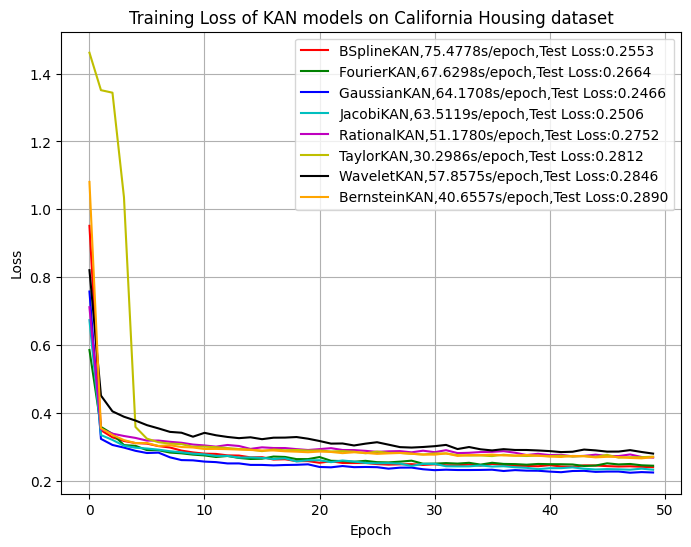

In [6]:
# Plot the loss curve
plt.figure(figsize=(8,6))
plt.plot(b_epoch_losses, label=f'BSplineKAN,{b_epoch_time:.4f}s/epoch,Test Loss:{b_test_loss:.4f}', color='r')
plt.plot(f_epoch_losses, label=f'FourierKAN,{f_epoch_time:.4f}s/epoch,Test Loss:{f_test_loss:.4f}', color='g')
plt.plot(g_epoch_losses, label=f'GaussianKAN,{g_epoch_time:.4f}s/epoch,Test Loss:{g_test_loss:.4f}', color='b')
plt.plot(j_epoch_losses, label=f'JacobiKAN,{j_epoch_time:.4f}s/epoch,Test Loss:{j_test_loss:.4f}', color='c')
plt.plot(r_epoch_losses, label=f'RationalKAN,{r_epoch_time:.4f}s/epoch,Test Loss:{r_test_loss:.4f}', color='m')
plt.plot(t_epoch_losses, label=f'TaylorKAN,{t_epoch_time:.4f}s/epoch,Test Loss:{t_test_loss:.4f}', color='y')
plt.plot(w_epoch_losses, label=f'WaveletKAN,{w_epoch_time:.4f}s/epoch,Test Loss:{w_test_loss:.4f}', color='k')
plt.plot(be_epoch_losses, label=f'BernsteinKAN,{be_epoch_time:.4f}s/epoch,Test Loss:{be_test_loss:.4f}', color='orange')
plt.plot(mlp_epoch_losses, label=f'MLP,{mlp_epoch_time:.4f}s/epoch,Test Loss:{mlp_test_loss:.4f}', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss of KAN models on California Housing dataset')
plt.grid(True)
plt.legend()
plt.show()

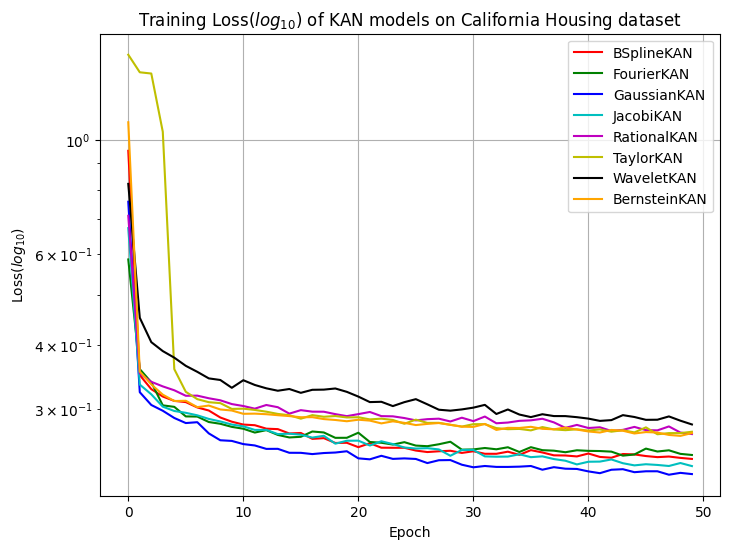

In [7]:
# Plot the loss curve(log)
plt.figure(figsize=(8,6))
plt.plot(b_epoch_losses, label=f'BSplineKAN', color='r')
plt.plot(f_epoch_losses, label=f'FourierKAN', color='g')
plt.plot(g_epoch_losses, label=f'GaussianKAN', color='b')
plt.plot(j_epoch_losses, label=f'JacobiKAN', color='c')
plt.plot(r_epoch_losses, label=f'RationalKAN', color='m')
plt.plot(t_epoch_losses, label=f'TaylorKAN', color='y')
plt.plot(w_epoch_losses, label=f'WaveletKAN', color='k')
plt.plot(be_epoch_losses, label=f'BernsteinKAN', color='orange')
plt.plot(mlp_epoch_losses, label=f'MLP', color='purple')
plt.xlabel('Epoch')
plt.ylabel('Loss($log_{10}$)')
plt.yscale('log')
plt.title('Training Loss($log_{10}$) of KAN models on California Housing dataset')
plt.grid(True)
plt.legend()
plt.show()